In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# :( 
# Null values
# Category/Strings for columns

In [5]:
# IMPUTATION

# Cabin is likely going to be dropped
# (is there any way to get info?)

# Embarked can likely be filled

# Age can be filled (but can we do it in a smart way?)

In [6]:
# Feature Engineering
df["Has_Cabin"] = df.Cabin.apply(lambda x: 1 if pd.notnull(x) else 0)
df.Has_Cabin.value_counts()

Has_Cabin
0    687
1    204
Name: count, dtype: int64

In [7]:
# Cabin can be safely dropped
df.drop(columns=["Cabin"], inplace=True)

In [8]:
# When missing a category - impute (fill) with the MODE or most frequent
df.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [9]:
# FILL with "S"
df["Embarked"] = df.Embarked.fillna("S")
df.Embarked.value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [10]:
# With numeric features, are to fill the mean or median
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [11]:
df.groupby("Sex").Age.describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0
male,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0


In [12]:
# For NULL Age WOMEN, fill with 27
# For NULL Age MEN fill with 29
# I believe that this smarter than filling with 28 for everyone

df.loc[(df.Sex == "male") & (pd.isnull(df.Age)), "Age"] = 29
df.loc[(df.Sex == "female") & (pd.isnull(df.Age)), "Age"] = 27

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Has_Cabin    891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


In [14]:
# Dealing with Strings
# Ticket, Name, Embarked, Sex, (Pclass), Has_Cabin
# Only four are categories: Embarked, Sex, PClass, Has_Cabin

# DROP: Ticket & Name columns
# Future work: Extract the titles from the NAME column to use as an additional category
cols_to_drop = ["Ticket", "Name"]
df.drop(columns=cols_to_drop, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin
0,1,0,3,male,22.0,1,0,7.2500,S,0
1,2,1,1,female,38.0,1,0,71.2833,C,1
2,3,1,3,female,26.0,0,0,7.9250,S,0
3,4,1,1,female,35.0,1,0,53.1000,S,1
4,5,0,3,male,35.0,0,0,8.0500,S,0


In [15]:
# Feature Engineering
# Combine SibSp + Parch to create ONE column for family_size
df["Family_Size"] = df.SibSp + df.Parch + 1
df.drop(columns=["SibSp", "Parch"], inplace=True)

In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
       'Has_Cabin', 'Family_Size'],
      dtype='object')

In [17]:
# Encoding, separate out features
meta = ['PassengerId', 'Survived']
num_features = ['Age', 'Fare', 'Family_Size']
cat_features = ['Pclass', 'Sex', 'Embarked', 'Has_Cabin']

In [18]:
# NUMERIC FIRST - Do we need a SCALER?
df_num = df.loc[:, num_features]
df_num.describe()

,Age,Fare,Family_Size
count,891.000000,891.000000,891.000000
mean,29.441268,32.204208,1.904602
std,13.018747,49.693429,1.613459
min,0.420000,0.000000,1.000000
25%,22.000000,7.910400,1.000000
50%,29.000000,14.454200,1.000000
75%,35.000000,31.000000,2.000000
max,80.000000,512.329200,11.000000


In [19]:
# YES we need a scaler

# initialize
scaler = StandardScaler()

# fit
scaler.fit(df_num)

# predict/transform
scaled_data = scaler.transform(df_num)
df_scaled = pd.DataFrame(scaled_data, columns=num_features)

df_scaled.head()

,Age,Fare,Family_Size
0,-0.571902,-0.502445,0.059160
1,0.657785,0.786845,0.059160
2,-0.264480,-0.488854,-0.560975
3,0.427219,0.420730,0.059160
4,0.427219,-0.486337,-0.560975


In [20]:
# NUMERIC features are ready to go

In [21]:
# Categorical Up Next
df_cat = df.loc[:, cat_features]
df_cat.head()

,Pclass,Sex,Embarked,Has_Cabin
0,3,male,S,0
1,1,female,C,1
2,3,female,S,0
3,1,female,S,1
4,3,male,S,0


In [22]:
# Label Encode SEX
df_cat["Sex"] = df_cat.Sex.apply(lambda x: 0 if x == "male" else 1)
df_cat.head()

,Pclass,Sex,Embarked,Has_Cabin
0,3,0,S,0
1,1,1,C,1
2,3,1,S,0
3,1,1,S,1
4,3,0,S,0


In [23]:
df_cat.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [24]:
# One Hot Encoding
df_cat["Pclass"] = df_cat.Pclass.astype(str)
df_cat = pd.get_dummies(df_cat, dtype=int)
df_cat.head()

,Sex,Has_Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,0,1,0,0,1
1,1,1,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,1,1,0,0,0,0,1
4,0,0,0,0,1,0,0,1


In [25]:
# Put Everything Back Together

df_final = df.loc[:, meta]
df_final = pd.concat([df_final, df_scaled], axis=1)
df_final = pd.concat([df_final, df_cat], axis=1)
df_final.head()

,PassengerId,Survived,Age,Fare,Family_Size,Sex,Has_Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,-0.571902,-0.502445,0.059160,0,0,0,0,1,0,0,1
1,2,1,0.657785,0.786845,0.059160,1,1,1,0,0,1,0,0
2,3,1,-0.264480,-0.488854,-0.560975,1,0,0,0,1,0,0,1
3,4,1,0.427219,0.420730,0.059160,1,1,1,0,0,0,0,1
4,5,0,0.427219,-0.486337,-0.560975,0,0,0,0,1,0,0,1


In [26]:
# Isolate the IDs for later (if needed)
ids = df_final.PassengerId
df_final.drop(columns=["PassengerId"], inplace=True)
df_final.head()

,Survived,Age,Fare,Family_Size,Sex,Has_Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,-0.571902,-0.502445,0.059160,0,0,0,0,1,0,0,1
1,1,0.657785,0.786845,0.059160,1,1,1,0,0,1,0,0
2,1,-0.264480,-0.488854,-0.560975,1,0,0,0,1,0,0,1
3,1,0.427219,0.420730,0.059160,1,1,1,0,0,0,0,1
4,0,0.427219,-0.486337,-0.560975,0,0,0,0,1,0,0,1


In [27]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Age          891 non-null    float64
 2   Fare         891 non-null    float64
 3   Family_Size  891 non-null    float64
 4   Sex          891 non-null    int64  
 5   Has_Cabin    891 non-null    int64  
 6   Pclass_1     891 non-null    int64  
 7   Pclass_2     891 non-null    int64  
 8   Pclass_3     891 non-null    int64  
 9   Embarked_C   891 non-null    int64  
 10  Embarked_Q   891 non-null    int64  
 11  Embarked_S   891 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 83.7 KB


In [28]:
# Copy/Paste Gauntlet

In [29]:
df_final.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [30]:
# Feature selection
# correlation analysis
corrs = df_final.corr()
corrs

,Survived,Age,Fare,Family_Size,Sex,Has_Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.073296,0.257307,0.016639,0.543351,0.316912,0.285904,0.093349,-0.322308,0.168240,0.003650,-0.149683
Age,-0.073296,1.000000,0.094161,-0.249501,-0.095256,0.238021,0.322871,0.014199,-0.289743,0.030385,-0.032994,-0.005855
Fare,0.257307,0.094161,1.000000,0.217138,0.182333,0.482075,0.591711,-0.118557,-0.413333,0.269335,-0.117216,-0.162184
Family_Size,0.016639,-0.249501,0.217138,1.000000,0.200988,-0.009175,-0.046114,-0.038594,0.071142,-0.046215,-0.058592,0.077359
Sex,0.543351,-0.095256,0.182333,0.200988,1.000000,0.140391,0.098013,0.064746,-0.137143,0.082853,0.074115,-0.119224
Has_Cabin,0.316912,0.238021,0.482075,-0.009175,0.140391,1.000000,0.788773,-0.172413,-0.539291,0.208528,-0.129572,-0.101139
Pclass_1,0.285904,0.322871,0.591711,-0.046114,0.098013,0.788773,1.000000,-0.288585,-0.626738,0.296423,-0.155342,-0.161921
Pclass_2,0.093349,0.014199,-0.118557,-0.038594,0.064746,-0.172413,-0.288585,1.000000,-0.565210,-0.125416,-0.127301,0.189980
Pclass_3,-0.322308,-0.289743,-0.413333,0.071142,-0.137143,-0.539291,-0.626738,-0.565210,1.000000,-0.153329,0.237449,-0.015104
Embarked_C,0.168240,0.030385,0.269335,-0.046215,0.082853,0.208528,0.296423,-0.125416,-0.153329,1.000000,-0.148258,-0.782742


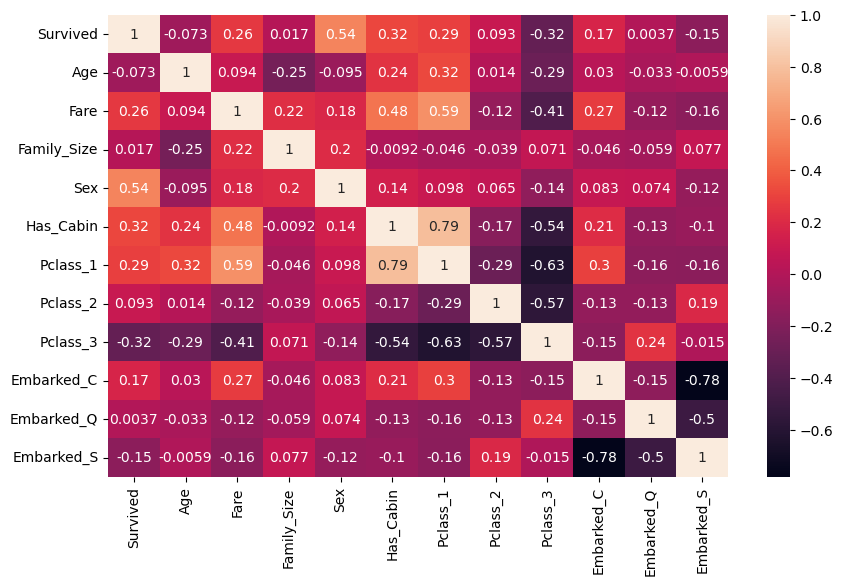

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(corrs, annot=True)
plt.show()

In [32]:
abs(corrs.Survived).sort_values(ascending=False)

Survived       1.000000
Sex            0.543351
Pclass_3       0.322308
Has_Cabin      0.316912
Pclass_1       0.285904
Fare           0.257307
Embarked_C     0.168240
Embarked_S     0.149683
Pclass_2       0.093349
Age            0.073296
Family_Size    0.016639
Embarked_Q     0.003650
Name: Survived, dtype: float64

In [33]:
# Step 1: Get the data
X = df_final.drop(columns=["Survived"])
y = df_final.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y) # stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)

(668, 11) (223, 11)


In [34]:
# Function for Classification
# THE ROC CURVE CODE WILL BREAK FOR MULTI_CLASS PROBLEMS
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

TRAIN METRICS
    Confusion Matrix: 
    [[362  50]
 [ 68 188]]
    
    AUC: 0.8673012742718447

    Classification Report:
                  precision    recall  f1-score   support

           0       0.84      0.88      0.86       412
           1       0.79      0.73      0.76       256

    accuracy                           0.82       668
   macro avg       0.82      0.81      0.81       668
weighted avg       0.82      0.82      0.82       668

    
TEST METRICS
    Confusion Matrix: 
    [[118  19]
 [ 28  58]]
    
    AUC: 0.8332201663554575

    Classification Report:
                  precision    recall  f1-score   support

           0       0.81      0.86      0.83       137
           1       0.75      0.67      0.71        86

    accuracy                           0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223

    


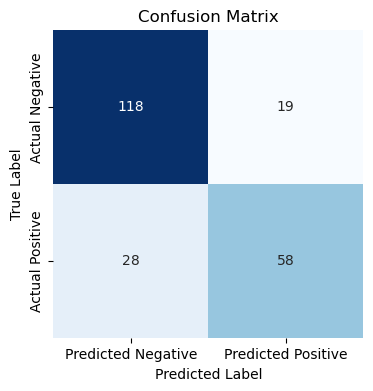

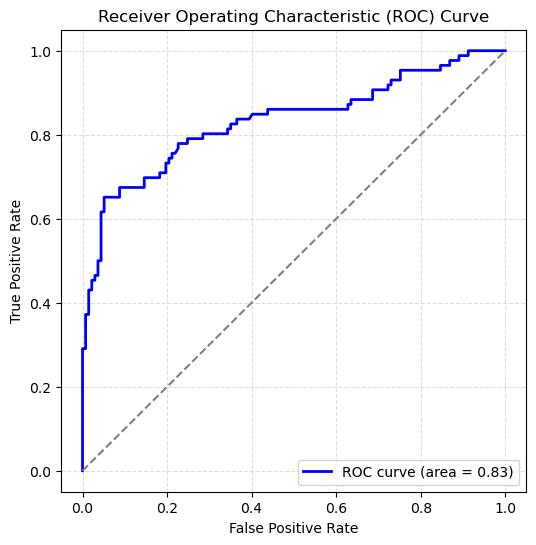

In [35]:
# Step 2: Init the Model
lr = LogisticRegression()

# Do Machine Learning
doClassification(lr, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[410   2]
 [  9 247]]
    
    AUC: 0.9991940989077671

    Classification Report:
                  precision    recall  f1-score   support

           0       0.98      1.00      0.99       412
           1       0.99      0.96      0.98       256

    accuracy                           0.98       668
   macro avg       0.99      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668

    
TEST METRICS
    Confusion Matrix: 
    [[113  24]
 [ 27  59]]
    
    AUC: 0.7480903072483449

    Classification Report:
                  precision    recall  f1-score   support

           0       0.81      0.82      0.82       137
           1       0.71      0.69      0.70        86

    accuracy                           0.77       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223

    


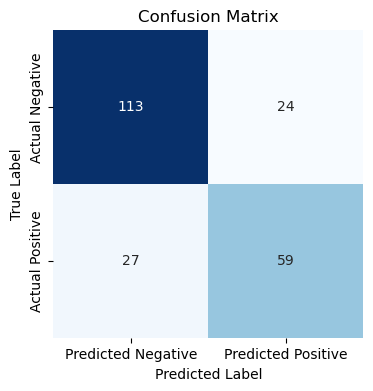

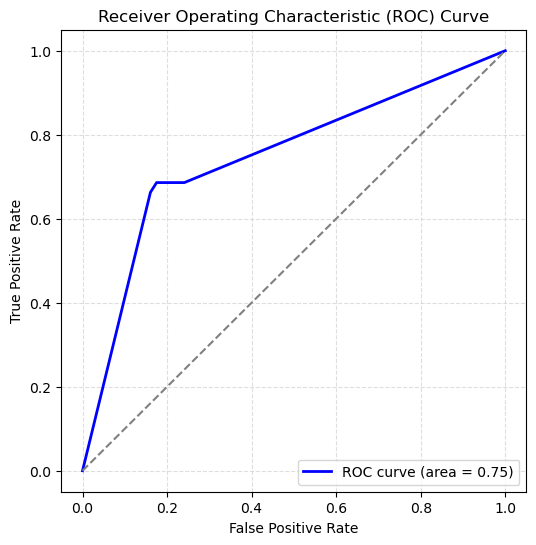

In [36]:
# Step 2: Init the Model
dt = DecisionTreeClassifier(random_state=42)

# Do Machine Learning
doClassification(dt, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[409   3]
 [  8 248]]
    
    AUC: 0.9973926729368933

    Classification Report:
                  precision    recall  f1-score   support

           0       0.98      0.99      0.99       412
           1       0.99      0.97      0.98       256

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668

    
TEST METRICS
    Confusion Matrix: 
    [[122  15]
 [ 24  62]]
    
    AUC: 0.8552877270412494

    Classification Report:
                  precision    recall  f1-score   support

           0       0.84      0.89      0.86       137
           1       0.81      0.72      0.76        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223

    


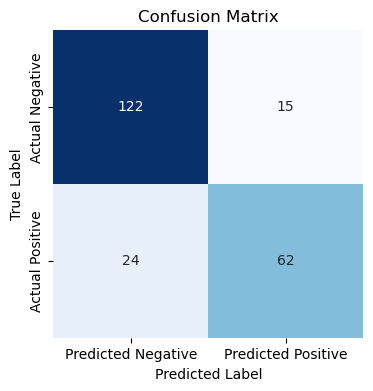

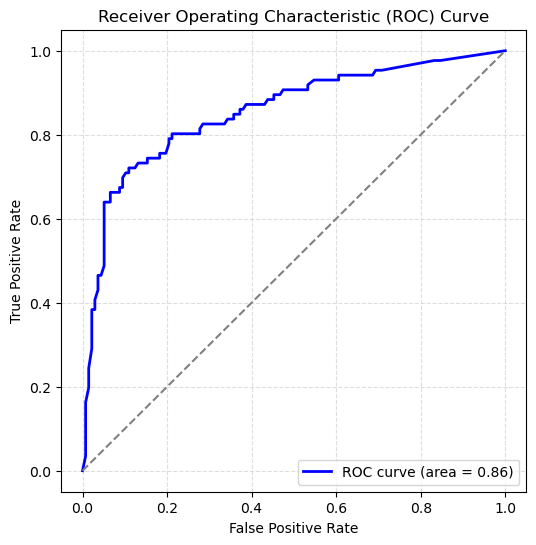

In [37]:
# Step 2: Init the Model
rf = RandomForestClassifier(random_state=42)

# Do Machine Learning
doClassification(rf, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[371  41]
 [ 68 188]]
    
    AUC: 0.8935167627427184

    Classification Report:
                  precision    recall  f1-score   support

           0       0.85      0.90      0.87       412
           1       0.82      0.73      0.78       256

    accuracy                           0.84       668
   macro avg       0.83      0.82      0.82       668
weighted avg       0.84      0.84      0.83       668

    
TEST METRICS
    Confusion Matrix: 
    [[125  12]
 [ 25  61]]
    
    AUC: 0.8237990154472925

    Classification Report:
                  precision    recall  f1-score   support

           0       0.83      0.91      0.87       137
           1       0.84      0.71      0.77        86

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223

    


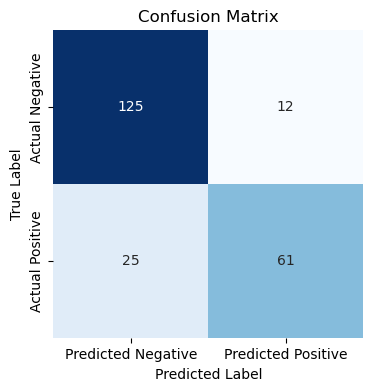

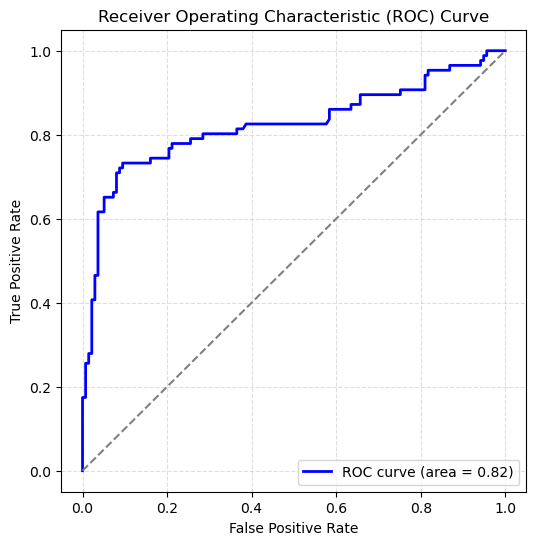

In [38]:
# Step 2: Init the Model
svc = SVC(probability=True)

# Do Machine Learning
doClassification(svc, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[360  52]
 [ 64 192]]
    
    AUC: 0.8977975197208736

    Classification Report:
                  precision    recall  f1-score   support

           0       0.85      0.87      0.86       412
           1       0.79      0.75      0.77       256

    accuracy                           0.83       668
   macro avg       0.82      0.81      0.81       668
weighted avg       0.83      0.83      0.83       668

    
TEST METRICS
    Confusion Matrix: 
    [[118  19]
 [ 28  58]]
    
    AUC: 0.8301222203361059

    Classification Report:
                  precision    recall  f1-score   support

           0       0.81      0.86      0.83       137
           1       0.75      0.67      0.71        86

    accuracy                           0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223

    


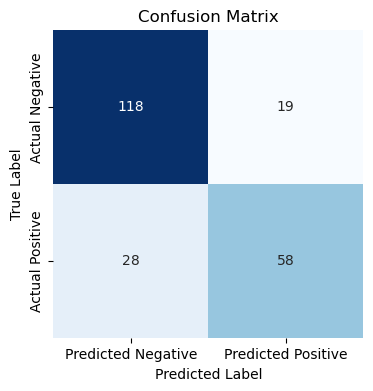

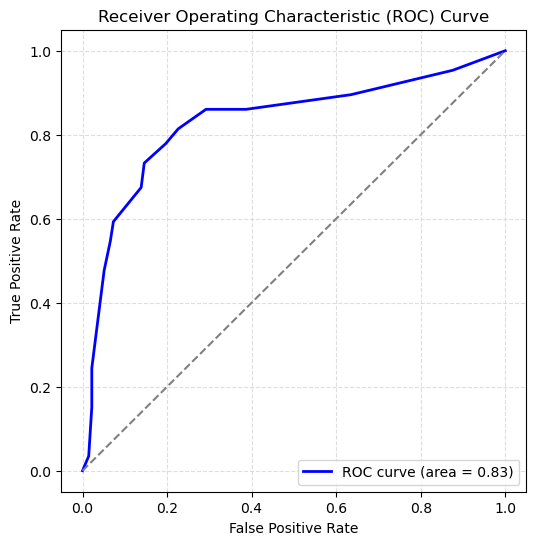

In [39]:
# Step 2: Init the Model
knn = KNeighborsClassifier(n_neighbors=15)

# Do Machine Learning
doClassification(knn, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[410   2]
 [  9 247]]
    
    AUC: 0.9991940989077671

    Classification Report:
                  precision    recall  f1-score   support

           0       0.98      1.00      0.99       412
           1       0.99      0.96      0.98       256

    accuracy                           0.98       668
   macro avg       0.99      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668

    
TEST METRICS
    Confusion Matrix: 
    [[118  19]
 [ 26  60]]
    
    AUC: 0.8378883041928366

    Classification Report:
                  precision    recall  f1-score   support

           0       0.82      0.86      0.84       137
           1       0.76      0.70      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223

    


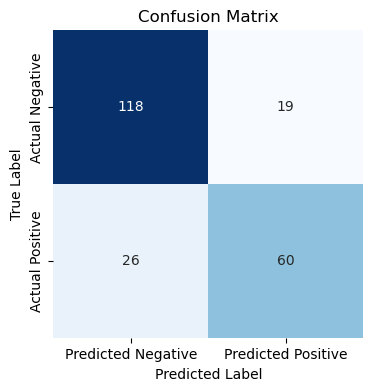

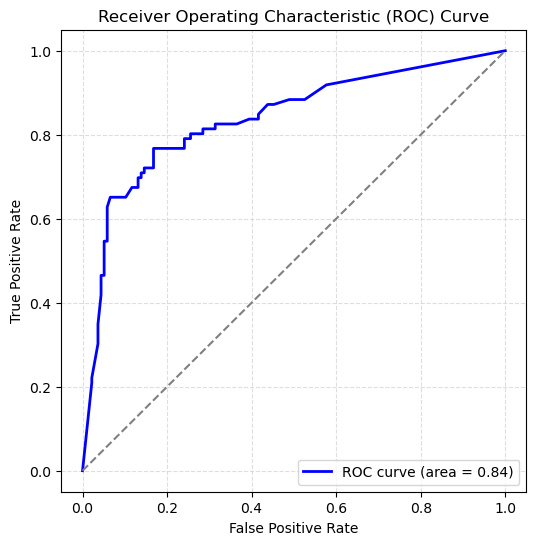

In [40]:
# Step 2: Init the Model
et = ExtraTreesClassifier(random_state=42)

# Do Machine Learning
doClassification(et, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[363  49]
 [ 51 205]]
    
    AUC: 0.9193956689927184

    Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.88      0.88       412
           1       0.81      0.80      0.80       256

    accuracy                           0.85       668
   macro avg       0.84      0.84      0.84       668
weighted avg       0.85      0.85      0.85       668

    
TEST METRICS
    Confusion Matrix: 
    [[119  18]
 [ 26  60]]
    
    AUC: 0.8198098794771685

    Classification Report:
                  precision    recall  f1-score   support

           0       0.82      0.87      0.84       137
           1       0.77      0.70      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223

    


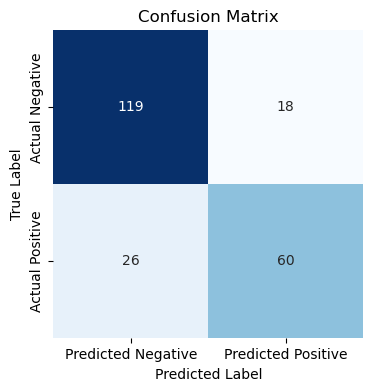

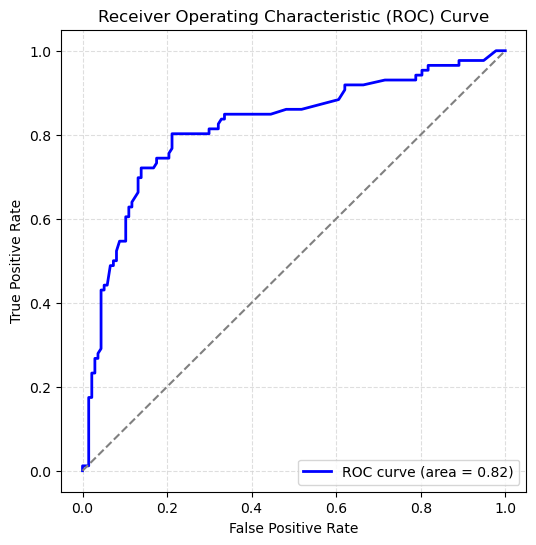

In [41]:
# Step 2: Init the Model
ada = AdaBoostClassifier(random_state=42)

# Do Machine Learning
doClassification(ada, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[394  18]
 [ 45 211]]
    
    AUC: 0.9600747117718447

    Classification Report:
                  precision    recall  f1-score   support

           0       0.90      0.96      0.93       412
           1       0.92      0.82      0.87       256

    accuracy                           0.91       668
   macro avg       0.91      0.89      0.90       668
weighted avg       0.91      0.91      0.90       668

    
TEST METRICS
    Confusion Matrix: 
    [[123  14]
 [ 27  59]]
    
    AUC: 0.8560516041419114

    Classification Report:
                  precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy                           0.82       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223

    


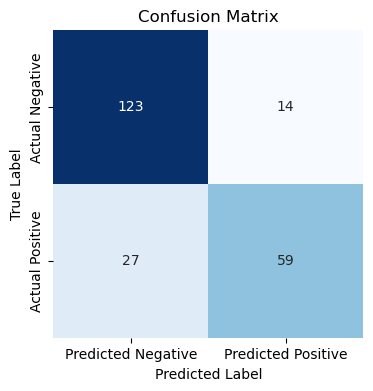

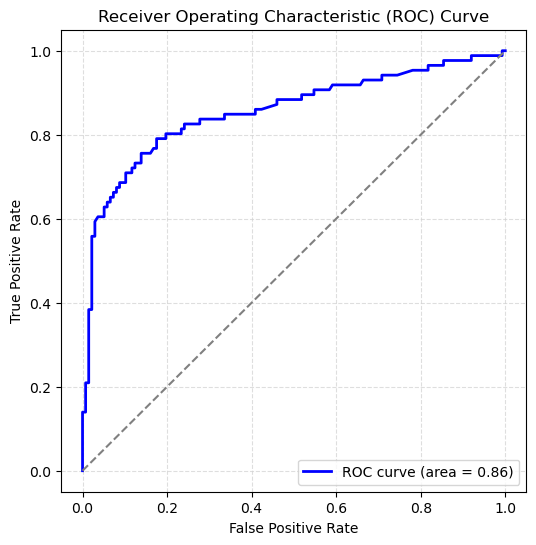

In [42]:
# Step 2: Init the Model
gb = GradientBoostingClassifier(random_state=42)

# Do Machine Learning
doClassification(gb, X_train, X_test, y_train, y_test)

In [43]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

TRAIN METRICS
    Confusion Matrix: 
    [[409   3]
 [ 15 241]]
    
    AUC: 0.9965298847087378

    Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.99      0.98       412
           1       0.99      0.94      0.96       256

    accuracy                           0.97       668
   macro avg       0.98      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668

    
TEST METRICS
    Confusion Matrix: 
    [[121  16]
 [ 21  65]]
    
    AUC: 0.850025462570022

    Classification Report:
                  precision    recall  f1-score   support

           0       0.85      0.88      0.87       137
           1       0.80      0.76      0.78        86

    accuracy                           0.83       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223

    


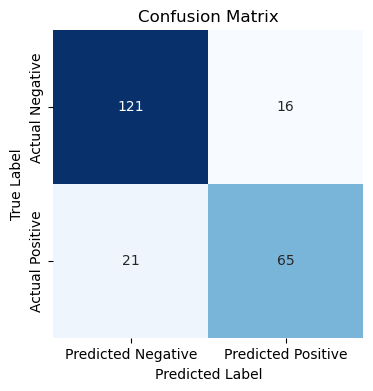

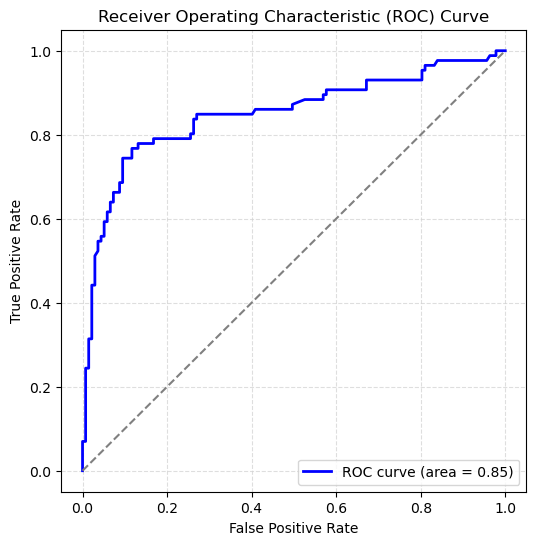

In [44]:
# Step 2: Init the Model
xgb = XGBClassifier(random_state=42)

# Do Machine Learning
doClassification(xgb, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[405   7]
 [ 21 235]]
    
    AUC: 0.9913721177184467

    Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.98      0.97       412
           1       0.97      0.92      0.94       256

    accuracy                           0.96       668
   macro avg       0.96      0.95      0.96       668
weighted avg       0.96      0.96      0.96       668

    
TEST METRICS
    Confusion Matrix: 
    [[121  16]
 [ 23  63]]
    
    AUC: 0.8518502800882702

    Classification Report:
                  precision    recall  f1-score   support

           0       0.84      0.88      0.86       137
           1       0.80      0.73      0.76        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223

    


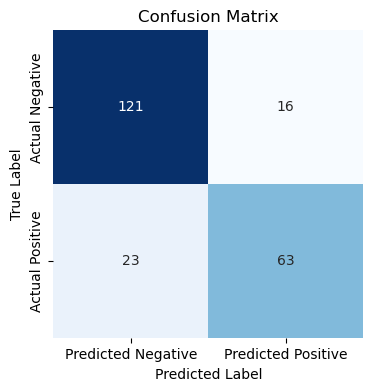

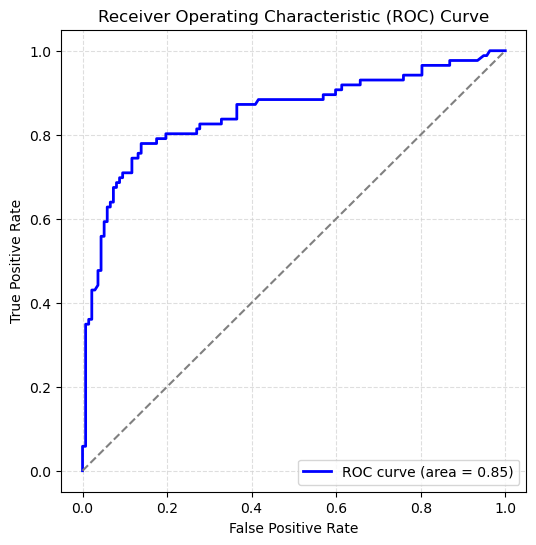

In [45]:
# Step 2: Init the Model
lgbm = LGBMClassifier(random_state=42, verbose=-1)

# Do Machine Learning
doClassification(lgbm, X_train, X_test, y_train, y_test)

In [46]:
fi = pd.DataFrame(list(zip(X.columns, gb.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
3,Sex,0.433305
1,Fare,0.152996
0,Age,0.141156
7,Pclass_3,0.115185
2,Family_Size,0.071720
4,Has_Cabin,0.053148
5,Pclass_1,0.013324
10,Embarked_S,0.007654
8,Embarked_C,0.006787
6,Pclass_2,0.003541


In [47]:
fi = pd.DataFrame(list(zip(X.columns, xgb.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
3,Sex,0.443296
7,Pclass_3,0.207132
4,Has_Cabin,0.122132
6,Pclass_2,0.061828
2,Family_Size,0.044069
1,Fare,0.029568
0,Age,0.027212
8,Embarked_C,0.021660
9,Embarked_Q,0.015537
5,Pclass_1,0.015102


In [48]:
fi = pd.DataFrame(list(zip(X.columns, lgbm.feature_importances_ / sum(lgbm.feature_importances_))), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
1,Fare,0.446345
0,Age,0.361198
2,Family_Size,0.056765
3,Sex,0.036159
10,Embarked_S,0.021773
4,Has_Cabin,0.019440
8,Embarked_C,0.019051
7,Pclass_3,0.018274
6,Pclass_2,0.009720
9,Embarked_Q,0.007387


In [49]:
fi = pd.DataFrame(list(zip(X.columns, ada.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
1,Fare,0.46
0,Age,0.28
2,Family_Size,0.10
3,Sex,0.06
7,Pclass_3,0.04
4,Has_Cabin,0.02
6,Pclass_2,0.02
10,Embarked_S,0.02
5,Pclass_1,0.00
8,Embarked_C,0.00


In [50]:
# Gradient Boosting is probably Best

In [51]:
# Part 3: Model Productionalization

In [ ]:
# Retrain the model on the ENTIRE dataset
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X, y)

In [ ]:
# Save off my models
import pickle

# Scaler
pickle.dump(scaler, open("titanic_scaler.h5", 'wb'))

# Model
pickle.dump(gb, open("titanic_model.h5", 'wb'))

In [ ]:
# Production Use Case

In [ ]:
df_test = pd.read_csv("test.csv")
df_test.head()

In [ ]:
df_test.info()

In [ ]:
# Imputation
df_test["Has_Cabin"] = df_test.Cabin.apply(lambda x: 1 if pd.notnull(x) else 0)
df_test["Embarked"] = df_test.Embarked.fillna("S")
df_test.loc[(df_test.Sex == "male") & (pd.isnull(df_test.Age)), "Age"] = 29
df_test.loc[(df_test.Sex == "female") & (pd.isnull(df_test.Age)), "Age"] = 27
df_test["Fare"] = df_test.Fare.fillna(14.45)

# Combine SibSp + Parch to create ONE column for family_size
df_test["Family_Size"] = df_test.SibSp + df_test.Parch + 1
df_test.drop(columns=["Cabin", "SibSp", "Parch", "Name", "Ticket"], inplace=True)

# Encoding
df_test["Sex"] = df_test.Sex.apply(lambda x: 0 if x == "male" else 1)
df_test["Pclass"] = df_test.Pclass.astype(str)
df_test = pd.get_dummies(df_test, dtype=int)
df_test.head()

In [ ]:
# Save IDs for later
ids = df_test.PassengerId
df_test.drop(columns=["PassengerId"], inplace=True)

In [ ]:
# Scaler
scaler = pickle.load(open("titanic_scaler.h5", 'rb'))

scaled_data = scaler.transform(df_test.loc[:, ["Age", "Fare", "Family_Size"]])
df_scaled2 = pd.DataFrame(scaled_data, columns=["Age", "Fare", "Family_Size"])

# replace
df_test["Age"] = df_scaled2.Age
df_test["Fare"] = df_scaled2.Fare
df_test["Family_Size"] = df_scaled2.Family_Size

df_test.head()

In [ ]:
# model
model = pickle.load(open("titanic_model.h5", 'rb'))

# columns in order
df_test = df_test.loc[:, ['Age', 'Fare', 'Family_Size', 'Sex', 'Has_Cabin', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]

preds = model.predict(df_test)
preds

In [ ]:
submission = pd.DataFrame()
submission["PassengerId"] = ids
submission["Survived"] = preds
submission.head()

In [ ]:
submission.to_csv("titanic_submission.csv", index=False)